In [1]:
# Set up the environment and path
import os

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

os.chdir('/content/drive/MyDrive/MDS_final project')

Mounted at /content/drive


# Preprocessing

In [2]:
import pandas as pd

# 讀取新上傳的清理後資料檔案
df = pd.read_csv("./zomato_combined.csv")

# 刪除 multiple_deliveries 欄位為空值的 row
df_cleaned = df.dropna(subset=['multiple_deliveries'])

# 刪除 Festival 欄位為 "Yes" 或 空值的 row
df_cleaned = df_cleaned[~((df_cleaned['Festival'] == 'Yes') | (df_cleaned['Festival'].isna()))]
df_cleaned.drop(columns=['Festival'])

# 檢查目前是否還有任何欄位包含空值
missing_summary = df_cleaned.isna().sum()
missing_summary




,0
Delivery_person_Age,0
Delivery_person_Ratings,0
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Order_Date,0
Time_Orderd,0
Time_Order_picked,0
Weather_conditions,0


In [3]:
# 建立 delayed 欄位：若 Time_taken (min) > Estimated_duration_minutes 則為 1，否則為 0
df_cleaned['delayed'] = (df_cleaned['Time_taken (min)'] > df_cleaned['Estimated_duration_minutes']).astype(int)
df_cleaned.head(5)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,...,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),order_datetime,distance_km,Estimated_duration_minutes,delayed
0,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,...,Snack,motorcycle,3.0,No,Metropolitian,46,2022-02-12 21:55:00,10.280582,46,0
1,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,...,Meal,motorcycle,1.0,No,Metropolitian,23,2022-02-13 14:55:00,6.242319,24,0
2,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,...,Drinks,scooter,1.0,No,Metropolitian,21,2022-03-04 17:30:00,13.787860,42,0
3,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,...,Buffet,motorcycle,0.0,No,Metropolitian,20,2022-02-13 09:20:00,2.930258,15,1
4,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,...,Snack,scooter,1.0,No,Metropolitian,41,2022-02-14 19:50:00,19.396618,55,0


In [4]:
# 匯入必要模組
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Step 3: 建立特徵欄位
X = df_cleaned.drop(columns=['delayed', 'order_datetime', 'Time_taken (min)', 'Estimated_duration_minutes'])
y = df_cleaned['delayed']

# Step 4: 時間欄位轉換與萃取特徵
X['Order_Date'] = pd.to_datetime(X['Order_Date'], format='%d-%m-%Y')
X['hour_ordered'] = pd.to_datetime(df_cleaned['Time_Orderd'], format='%H:%M', errors='coerce').dt.hour
X['hour_picked'] = pd.to_datetime(df_cleaned['Time_Order_picked'], format='%H:%M', errors='coerce').dt.hour
X['day_of_week'] = X['Order_Date'].dt.dayofweek.astype('category')

# Step 5: 時段分類（自訂分類）
def assign_time_segment(hour):
    if pd.isnull(hour):
        return 'unknown'
    elif 8 <= hour <= 11:
        return 'morning_noon'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif hour >= 17:
        return 'evening'
    else:
        return 'other'

X['time_segment'] = X['hour_ordered'].apply(assign_time_segment)

# Step 6: 移除原始時間欄位
X = X.drop(columns=['Time_Orderd', 'Time_Order_picked'])

# Step 7: 特徵分類
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'datetime64']).columns.tolist()

# Step 8: 建立前處理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Step 9: 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




# EDA

In [9]:
# 為了便於 EDA，建立一份副本避免動到原始資料
eda_df = df_cleaned.copy()
delay_counts = eda_df['delayed'].value_counts()
delay_proportions = eda_df['delayed'].value_counts(normalize=True)

# 合併成一個 DataFrame
delay_summary = pd.DataFrame({
    'count': delay_counts,
    'proportion': delay_proportions
})

print(delay_summary)

         count  proportion
delayed                   
0        24432    0.629123
1        14403    0.370877


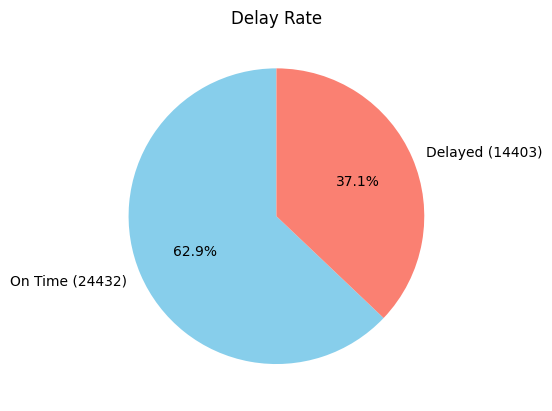

In [12]:
import matplotlib.pyplot as plt

# 計算 delay 的次數
delay_counts = eda_df['delayed'].value_counts()

# 建立標籤（含數量）
labels = [f'On Time ({delay_counts[0]})', f'Delayed ({delay_counts[1]})']
colors = ['skyblue', 'salmon']

# 繪製圓餅圖
delay_counts.plot.pie(
    labels=labels,
    colors=colors,
    autopct='%.1f%%',
    startangle=90
)

plt.title('Delay Rate')
plt.ylabel('')
plt.show()


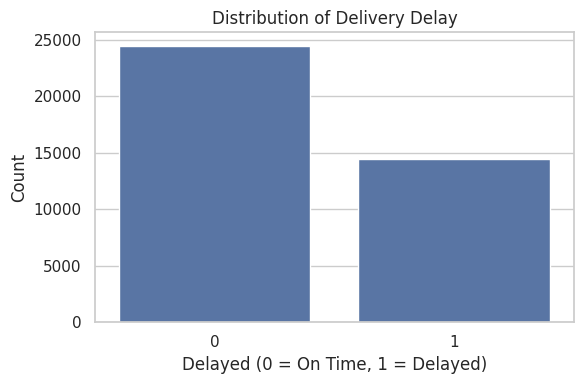

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 為了便於 EDA，建立一份副本避免動到原始資料
eda_df = df_cleaned.copy()

# 設定繪圖風格
sns.set(style="whitegrid")

# 繪製 EDA 圖表
# Delay 筆數統計
plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x='delayed')
plt.title('Distribution of Delivery Delay')
plt.xlabel('Delayed (0 = On Time, 1 = Delayed)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# # 數值欄位與延遲的關聯性 heatmap
# plt.figure(figsize=(10, 6))
# corr = eda_df[['Delivery_person_Age', 'Delivery_person_Ratings', 'multiple_deliveries',
#                'distance_km', 'Estimated_duration_minutes', 'Time_taken (min)', 'delayed']].corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Heatmap of Numeric Features')
# plt.tight_layout()
# plt.show()


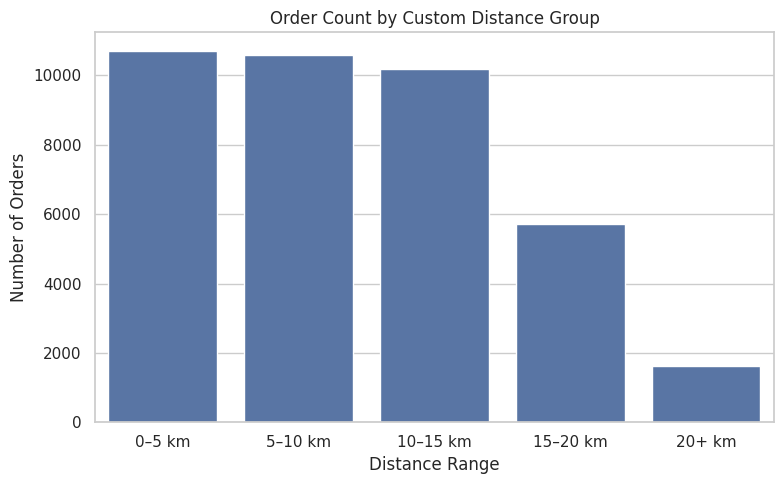

In [ ]:
# 自訂距離分組（手動切分）
distance_bins = [0, 5, 10, 15, 20, float('inf')]
distance_labels = ['0–5 km', '5–10 km', '10–15 km', '15–20 km', '20+ km']

eda_df['distance_group'] = pd.cut(eda_df['distance_km'], bins=distance_bins, labels=distance_labels)

# 統計每組的訂單數量
group_counts = eda_df['distance_group'].value_counts().sort_index().reset_index()
group_counts.columns = ['Distance Group', 'Order Count']

# 繪圖
plt.figure(figsize=(8, 5))
sns.barplot(data=group_counts, x='Distance Group', y='Order Count')
plt.title('Order Count by Custom Distance Group')
plt.xlabel('Distance Range')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()


<ipython-input-54-a7b75ef2f581>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=eda_df, x='delayed', y=col, palette=custom_palette)
<ipython-input-54-a7b75ef2f581>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=eda_df, x='delayed', y=col, palette=custom_palette)
<ipython-input-54-a7b75ef2f581>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=eda_df, x='delayed', y=col, palette=custom_palette)
<ipython-input-54-a7b75ef2f581>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

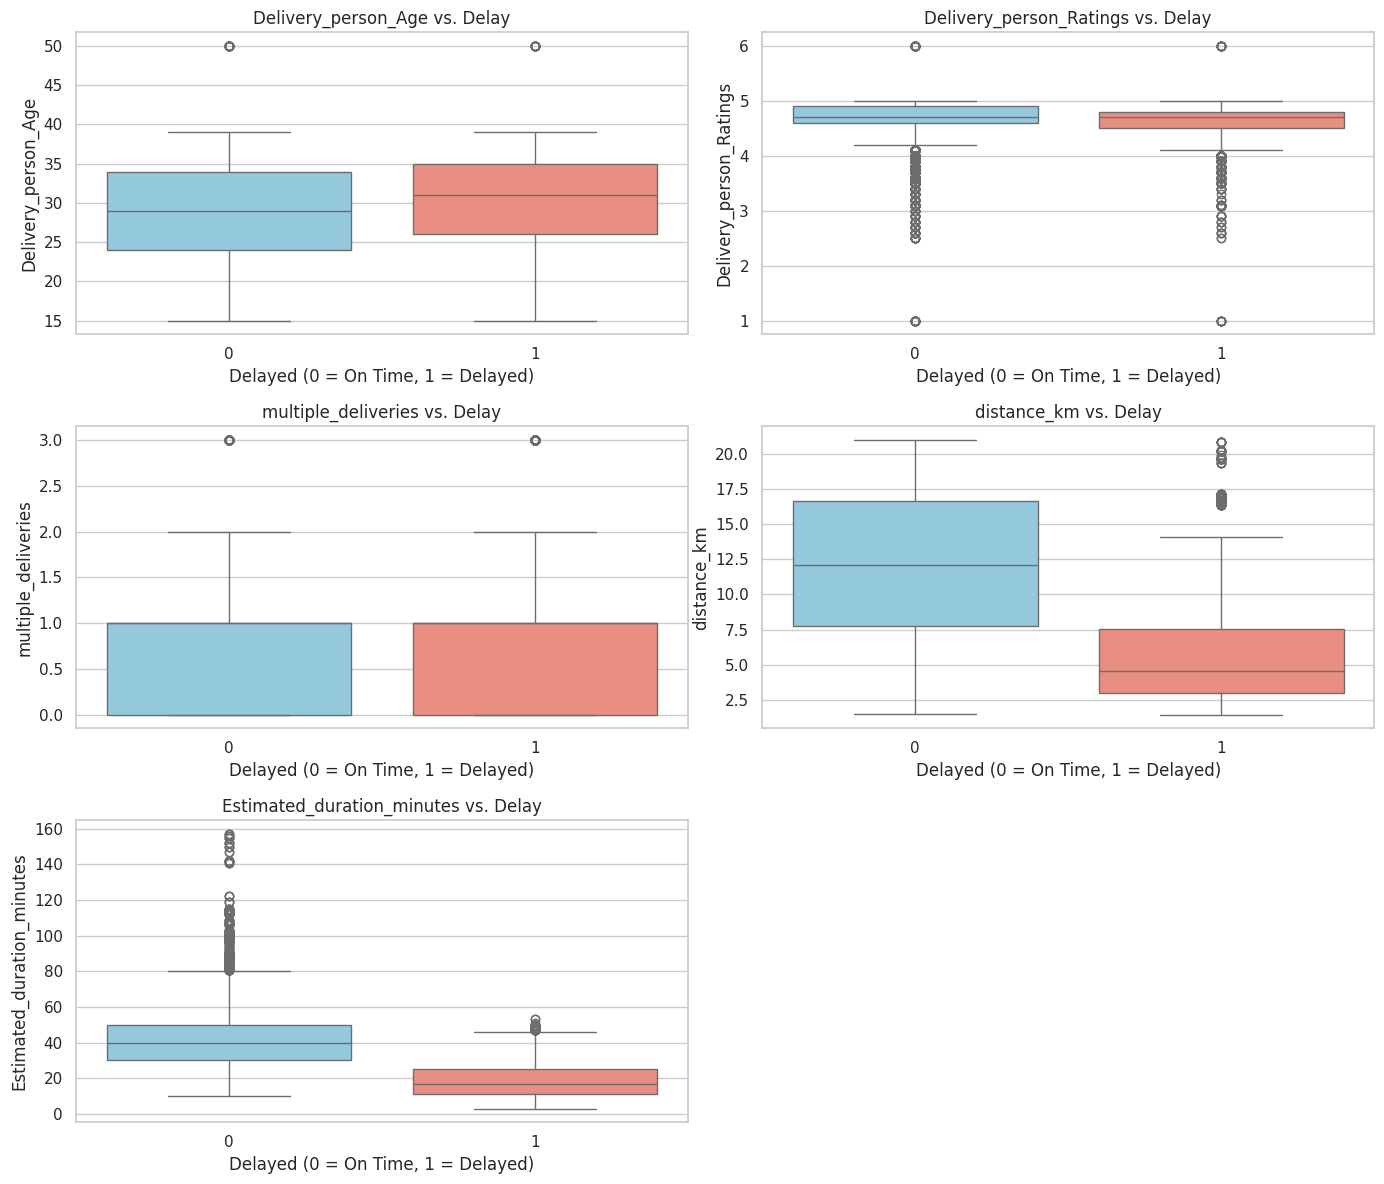

In [ ]:
# # 選出數值欄位與 delayed 欄位
# numeric_columns = ['Delivery_person_Age', 'Delivery_person_Ratings',
#                    'multiple_deliveries', 'distance_km', 'Estimated_duration_minutes']

# # 建立子圖畫布
# n_cols = 2
# n_rows = (len(numeric_columns) + 1) // n_cols

# plt.figure(figsize=(14, 4 * n_rows))

# # 每個數值欄位畫一張 boxplot
# for i, col in enumerate(numeric_columns, 1):
#     plt.subplot(n_rows, n_cols, i)
#     sns.boxplot(data=eda_df, x='delayed', y=col)
#     plt.title(f'{col} vs. Delay')
#     plt.xlabel('Delayed (0 = On Time, 1 = Delayed)')
#     plt.ylabel(col)

# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# 正確的 palette：key 為整數
custom_palette = {'0': 'skyblue', '1': 'salmon'}
numeric_columns = ['Delivery_person_Age', 'Delivery_person_Ratings',
                   'multiple_deliveries', 'distance_km', 'Estimated_duration_minutes']

n_cols = 2
n_rows = (len(numeric_columns) + 1) // n_cols

plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=eda_df, x='delayed', y=col, palette=custom_palette)
    plt.title(f'{col} vs. Delay')
    plt.xlabel('Delayed (0 = On Time, 1 = Delayed)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


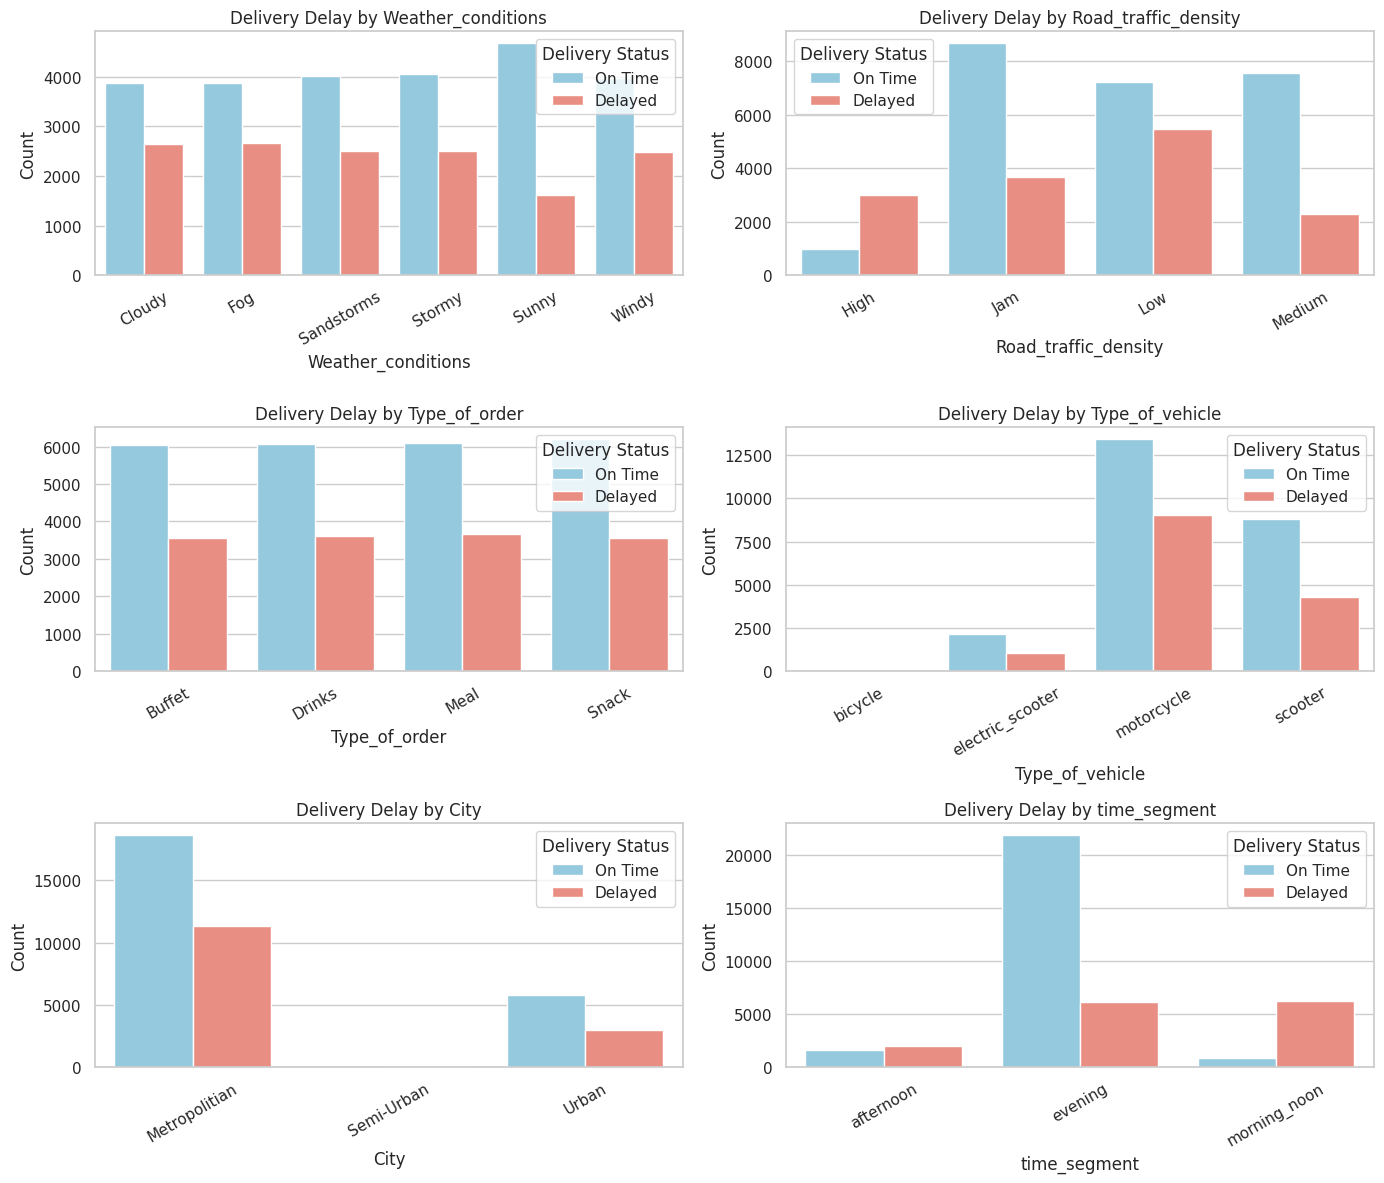

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 確保有正確的時間欄位
eda_df['Order_Date'] = pd.to_datetime(eda_df['Order_Date'], format='%d-%m-%Y')
eda_df['hour_ordered'] = pd.to_datetime(eda_df['Time_Orderd'], format='%H:%M', errors='coerce').dt.hour
eda_df['day_of_week'] = eda_df['Order_Date'].dt.day_name()

# 建立 day_of_week
eda_df['day_of_week'] = eda_df['Order_Date'].dt.dayofweek.astype('category')

# 建立 time_segment 分類
def assign_time_segment(hour):
    if pd.isnull(hour):
        return 'unknown'
    elif 8 <= hour <= 11:
        return 'morning_noon'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif hour >= 17:
        return 'evening'
    else:
        return 'other'

eda_df['time_segment'] = eda_df['hour_ordered'].apply(assign_time_segment)


# 類別變項清單（你可根據實際資料擴充）
categorical_vars = [
    'Weather_conditions', 'Road_traffic_density', 'Type_of_order',
    'Type_of_vehicle', 'City', 'time_segment'
]

# 建立多張圖表的畫布
n_cols = 2
n_rows = (len(categorical_vars) + 1) // n_cols
plt.figure(figsize=(14, 4 * n_rows))
# 自訂 palette，對應準時與延遲
custom_palette = {'On Time': 'skyblue', 'Delayed': 'salmon'}

# 每個類別變項畫一張 bar chart
for i, col in enumerate(categorical_vars, 1):
    ax = plt.subplot(n_rows, n_cols, i)

    # 計算每個類別與延遲的筆數
    plot_df = eda_df.groupby([col, 'delayed']).size().reset_index(name='Count')
    plot_df['Delayed_Label'] = plot_df['delayed'].map({0: 'On Time', 1: 'Delayed'})

    # 繪圖
    sns.barplot(data=plot_df, x=col, y='Count', hue='Delayed_Label', ax=ax, palette=custom_palette)
    ax.set_title(f'Delivery Delay by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=30)
    ax.legend(title='Delivery Status')

plt.tight_layout()
plt.show()


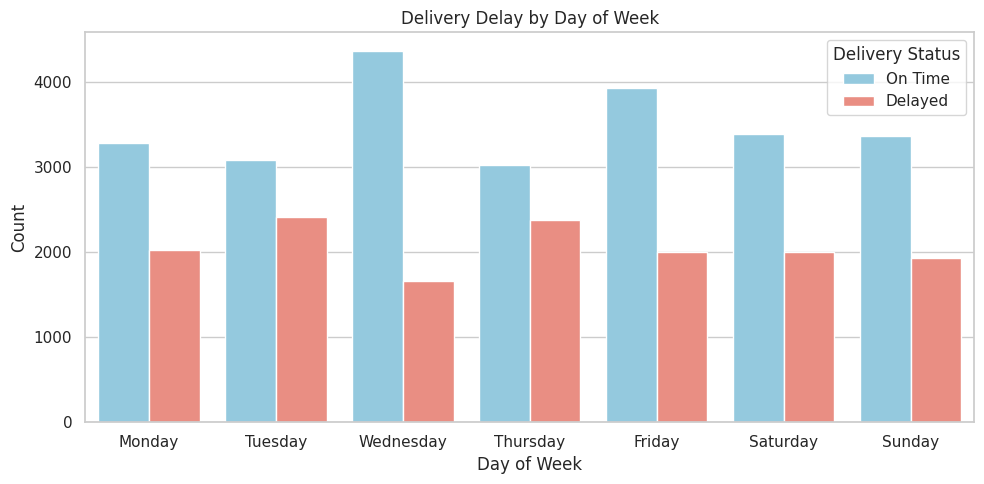

In [ ]:
# 將 day_of_week 從數字改成英文星期名
eda_df['day_of_week'] = eda_df['Order_Date'].dt.day_name()

# 重新繪製 day_of_week 對 delay 的分組長條圖
day_plot_df = eda_df.groupby(['day_of_week', 'delayed']).size().reset_index(name='Count')
day_plot_df['Delayed_Label'] = day_plot_df['delayed'].map({0: 'On Time', 1: 'Delayed'})

# 為了讓星期順序正確排序
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_plot_df['day_of_week'] = pd.Categorical(day_plot_df['day_of_week'], categories=day_order, ordered=True)

# 畫圖
plt.figure(figsize=(10, 5))
sns.barplot(data=day_plot_df, x='day_of_week', y='Count', hue='Delayed_Label', palette=custom_palette)
plt.title('Delivery Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Delivery Status')
plt.tight_layout()
plt.show()


# Logistic Regression

In [ ]:


# Step 9: 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 10: 建立 pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Step 11: 模型訓練與預測
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Step 12: 評估結果
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
)


from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# 定義交叉驗證方式（10 摺，保留類別比例）
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 執行交叉驗證並計算平均分數
cv_accuracy = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(pipeline, X, y, cv=cv, scoring='precision')
cv_recall = cross_val_score(pipeline, X, y, cv=cv, scoring='recall')
cv_f1 = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
cv_roc_auc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

# 結果整理與輸出
print("\n10-Fold Cross Validation Summary:")
print(f"Accuracy : {np.mean(cv_accuracy):.4f}")
print(f"Precision: {np.mean(cv_precision):.4f}")
print(f"Recall   : {np.mean(cv_recall):.4f}")
print(f"F1 Score : {np.mean(cv_f1):.4f}")
print(f"ROC AUC  : {np.mean(cv_roc_auc):.4f}")

# # 計算整體 precision/recall/f1（針對 class 1，延遲）
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

# # 顯示結果
# print("Confusion Matrix:")
# print(conf_matrix)
# print("\nMetrics Summary:")
# print(f"Accuracy : {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall   : {recall:.4f}")
# print(f"F1 Score : {f1:.4f}")
# print(f"ROC AUC  : {roc_auc:.4f}")



10-Fold Cross Validation Summary:
Accuracy : 0.8350
Precision: 0.7959
Recall   : 0.7468
F1 Score : 0.7705
ROC AUC  : 0.9090


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 建立新的 pipeline，將分類器改為 RandomForest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
])

# 使用原本的 train/test 資料集做訓練與預測
rf_pipeline.fit(X_train, y_train)
rf_y_pred = rf_pipeline.predict(X_test)

# 評估結果
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
)

# rf_accuracy = accuracy_score(y_test, rf_y_pred)
# rf_precision = precision_score(y_test, rf_y_pred)
# rf_recall = recall_score(y_test, rf_y_pred)
# rf_f1 = f1_score(y_test, rf_y_pred)
# rf_roc_auc = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
# rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

# # 顯示混淆矩陣與結果
# print("Confusion Matrix:")
# print(rf_conf_matrix)
# print("\nMetrics Summary:")
# print(f"Accuracy : {rf_accuracy:.4f}")
# print(f"Precision: {rf_precision:.4f}")
# print(f"Recall   : {rf_recall:.4f}")
# print(f"F1 Score : {rf_f1:.4f}")
# print(f"ROC AUC  : {rf_roc_auc:.4f}")

# Cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rf_cv_accuracy = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='accuracy')
rf_cv_precision = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='precision')
rf_cv_recall = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='recall')
rf_cv_f1 = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='f1')
rf_cv_roc_auc = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='roc_auc')

# 顯示 cross-validation 結果
print("\n10-Fold Cross Validation Summary:")
print(f"Accuracy : {rf_cv_accuracy.mean():.4f}")
print(f"Precision: {rf_cv_precision.mean():.4f}")
print(f"Recall   : {rf_cv_recall.mean():.4f}")
print(f"F1 Score : {rf_cv_f1.mean():.4f}")
print(f"ROC AUC  : {rf_cv_roc_auc.mean():.4f}")



10-Fold Cross Validation Summary:
Accuracy : 0.8733
Precision: 0.8545
Recall   : 0.7935
F1 Score : 0.8228
ROC AUC  : 0.9476


# XGBoost

In [14]:
from xgboost import XGBClassifier

# 建立新的 pipeline，將分類器改為 XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# 訓練與預測
xgb_pipeline.fit(X_train, y_train)
xgb_y_pred = xgb_pipeline.predict(X_test)

# # 評估結果
# xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
# xgb_precision = precision_score(y_test, xgb_y_pred)
# xgb_recall = recall_score(y_test, xgb_y_pred)
# xgb_f1 = f1_score(y_test, xgb_y_pred)
# xgb_roc_auc = roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])
# xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# # 顯示結果
# print("Confusion Matrix:")
# print(xgb_conf_matrix)
# print("\nMetrics Summary:")
# print(f"Accuracy : {xgb_accuracy:.4f}")
# print(f"Precision: {xgb_precision:.4f}")
# print(f"Recall   : {xgb_recall:.4f}")
# print(f"F1 Score : {xgb_f1:.4f}")
# print(f"ROC AUC  : {xgb_roc_auc:.4f}")

# Cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

xgb_cv_accuracy = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='accuracy')
xgb_cv_precision = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='precision')
xgb_cv_recall = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='recall')
xgb_cv_f1 = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='f1')
xgb_cv_roc_auc = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='roc_auc')

# 顯示交叉驗證結果
print("\n10-Fold Cross Validation Summary:")
print(f"Accuracy : {xgb_cv_accuracy.mean():.4f}")
print(f"Precision: {xgb_cv_precision.mean():.4f}")
print(f"Recall   : {xgb_cv_recall.mean():.4f}")
print(f"F1 Score : {xgb_cv_f1.mean():.4f}")
print(f"ROC AUC  : {xgb_cv_roc_auc.mean():.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


10-Fold Cross Validation Summary:
Accuracy : 0.8890
Precision: 0.8600
Recall   : 0.8374
F1 Score : 0.8484
ROC AUC  : 0.9608


# SHAP Analysis

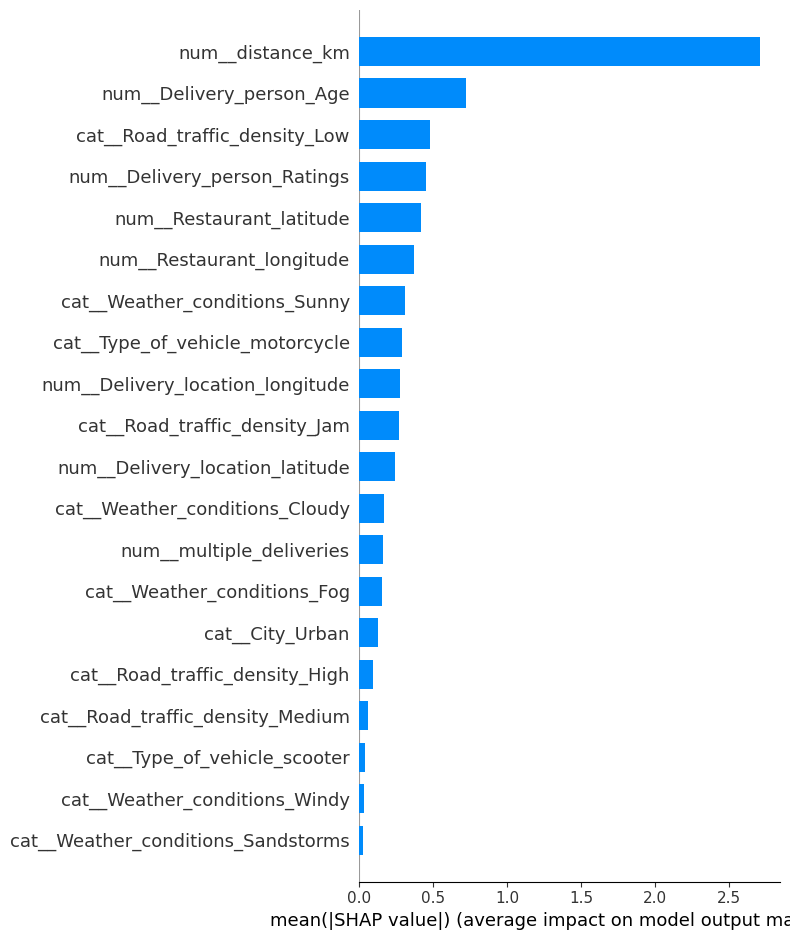

In [16]:
import shap

# 取得 XGBoost 模型（已包含在 pipeline 中）
xgb_model = xgb_pipeline.named_steps['classifier']

# 對資料進行轉換（使用預處理器）
X_transformed = preprocessor.transform(X_test)

# 建立 SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_transformed)

# 取得特徵名稱（使用 ColumnTransformer 的 get_feature_names_out 方法）
feature_names = preprocessor.get_feature_names_out()

# 重新繪製 shap summary plot 並顯示特徵名稱
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, plot_type="bar")




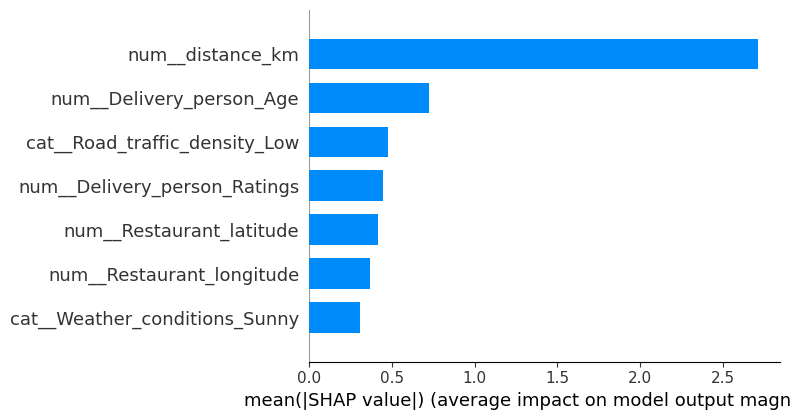

In [17]:
# 只顯示前 7 筆
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=feature_names,
    plot_type="bar",
    max_display=7
)

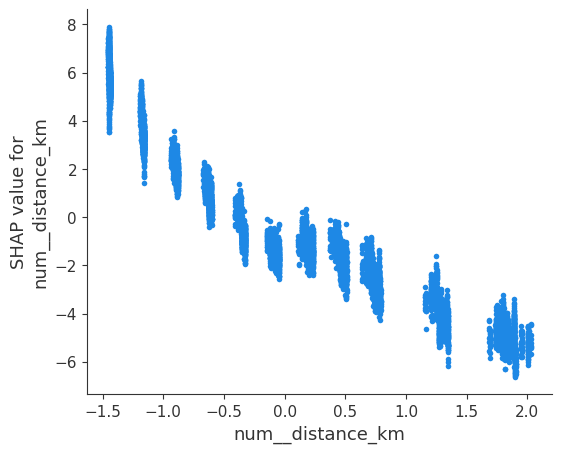

<function shap.plots._scatter.dependence_legacy(ind, shap_values=None, features=None, feature_names=None, display_features=None, interaction_index='auto', color='#1E88E5', axis_color='#333333', cmap=None, dot_size=16, x_jitter=0, alpha=1, title=None, xmin=None, xmax=None, ax=None, show=True, ymin=None, ymax=None)>

In [ ]:
# 重新匯入 shap 並執行 dependence plot
import shap
import pandas as pd

# 將 sparse matrix 轉成 dense 並包成 DataFrame
X_trans_df = pd.DataFrame(X_transformed.toarray(), columns=feature_names)


shap.dependence_plot(
    ind="num__distance_km",
    shap_values=shap_values.values,
    features=X_trans_df,
    feature_names=feature_names,
    interaction_index=None  # ❌ 不畫交互變數顏色
)
shap.dependence_plot

# 繪製 SHAP dependence plot
# shap.dependence_plot(
#     ind="num__distance_km",
#     shap_values=shap_values.values,  # ✅ 取出 SHAP value 的 array
#     features=X_trans_df,
#     feature_names=feature_names
# )
# shap.dependence_plot

# shap.dependence_plot(
#     ind="num__distance_km",
#     shap_values=shap_values.values,
#     features=X_trans_df,
#     feature_names=feature_names,
#     interaction_index="num__Delivery_person_Age"  # ✅ 指定畫年齡作為顏色
# )



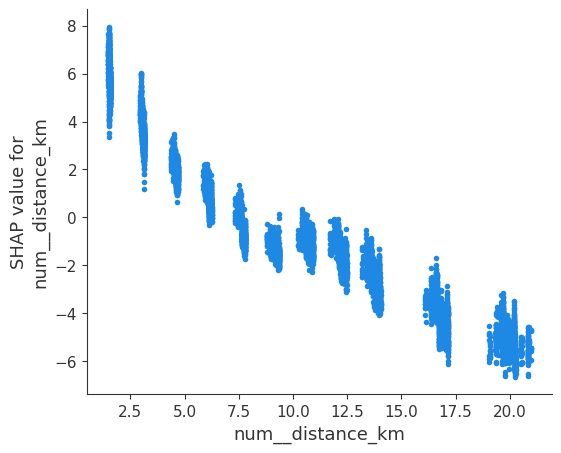

In [ ]:
# 複製一份 X_trans_df 避免改到原始
X_shap_plot = X_trans_df.copy()

# 找出 distance_km 在原始欄位中的 index
distance_col = 'num__distance_km'

# 取出未標準化的原始距離（從原始 X_test）
original_distance = X_test['distance_km'].reset_index(drop=True)

# 用原始值取代標準化後的欄位
X_shap_plot[distance_col] = original_distance

# 再次畫圖
shap.dependence_plot(
    ind=distance_col,
    shap_values=shap_values.values,
    features=X_shap_plot,
    feature_names=feature_names,
    interaction_index=None
)


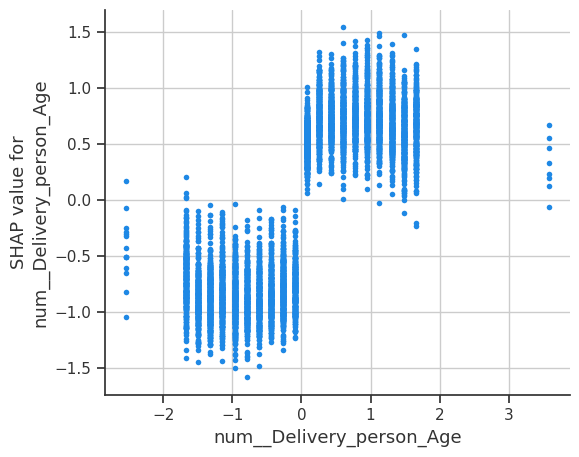

In [ ]:
import shap
import pandas as pd

# 將 sparse matrix 轉成 dense 並包成 DataFrame
X_trans_df = pd.DataFrame(X_transformed.toarray(), columns=feature_names)

# 繪製針對 Delivery person age 的 SHAP dependence plot
shap.dependence_plot(
    ind="num__Delivery_person_Age",
    shap_values=shap_values.values,
    features=X_trans_df,
    feature_names=feature_names,
    interaction_index=None  # ❌ 不畫交互變數顏色
)


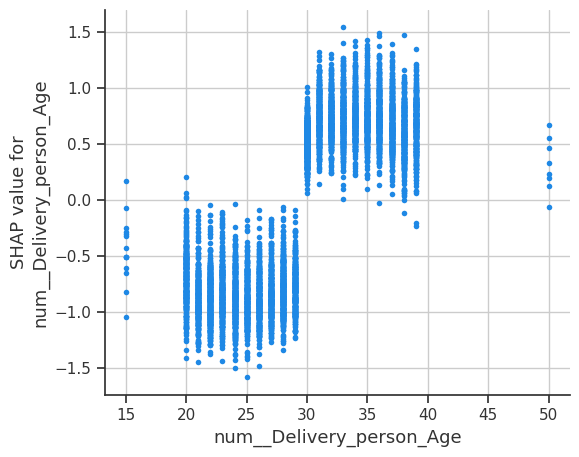

In [ ]:
import shap
import pandas as pd

# 將 sparse matrix 轉回 dense，建立 DataFrame
X_trans_df = pd.DataFrame(X_transformed.toarray(), columns=feature_names)

# 找到標準化欄位名稱
age_col = 'num__Delivery_person_Age'

# 從 X_test 取出原始年齡資料
original_age = X_test['Delivery_person_Age'].reset_index(drop=True)

# 將標準化欄位覆蓋成原始年齡
X_trans_df[age_col] = original_age

# 繪製 SHAP dependence plot（使用原始年齡作為 X 軸）
shap.dependence_plot(
    ind=age_col,
    shap_values=shap_values.values,
    features=X_trans_df,
    feature_names=feature_names,
    interaction_index=None  # 不加入顏色交互變數
)


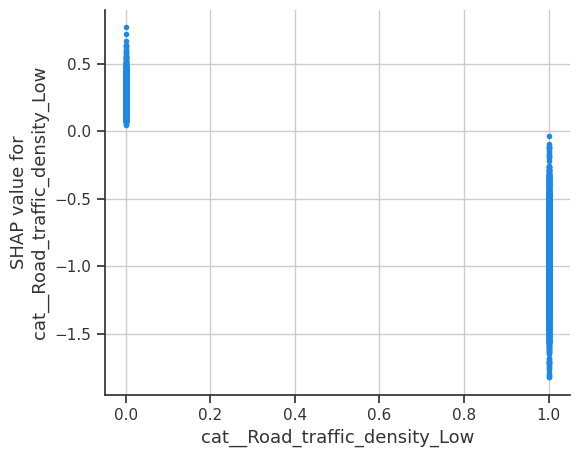

In [ ]:
shap.dependence_plot(
    ind="cat__Road_traffic_density_Low",
    shap_values=shap_values.values,
    features=X_trans_df,
    feature_names=feature_names,
    interaction_index=None
)

In [ ]:
import pandas as pd

# 從 X_test 中取出前 5 筆資料
sample_orders = X_test.head(5).reset_index(drop=True)

# 預測延遲機率與 SHAP 解釋
results = []

for i in range(len(sample_orders)):
    raw_order = sample_orders.iloc[[i]]  # 1. 保留原始 DataFrame 格式

    # 2. 做前處理轉換（這是重點）
    order_transformed = xgb_pipeline.named_steps['preprocessor'].transform(raw_order)

    # 3. 預測延遲機率
    prob = xgb_pipeline.named_steps['classifier'].predict_proba(order_transformed)[:, 1][0]

    # 4. 延遲風險分類
    if prob > 0.7:
        risk_level = "high"
    elif prob >= 0.3:
        risk_level = "medium"
    else:
        risk_level = "low"

    # 5. 使用轉換後資料來做 SHAP 解釋
    shap_values_i = explainer(order_transformed)

    # 6. 取得 SHAP 值並列出前 5 大
    feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

    shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_value': shap_values_i.values[0]}).sort_values(by='shap_value', ascending=False).head(5)

    results.append({
        'delay_prob':  float(f"{prob:.4f}"),
        'delay_risk_level': risk_level,
        'top_factors': shap_df.reset_index(drop=True)

    })


results

[{'delay_prob': 0.7068,
  'delay_risk_level': 'high',
  'top_factors':                            feature  shap_value
  0                 num__distance_km    2.127949
  1         num__Delivery_person_Age    0.556724
  2         num__Restaurant_latitude    0.497460
  3  cat__Type_of_vehicle_motorcycle    0.288985
  4    cat__Weather_conditions_Sunny    0.152717},
 {'delay_prob': 0.0,
  'delay_risk_level': 'low',
  'top_factors':                                          feature  shap_value
  0  cat__Order_Date_2022-03-29T00:00:00.000000000    0.139152
  1                  cat__Road_traffic_density_Low    0.128485
  2                                cat__City_Urban    0.055350
  3                 cat__Weather_conditions_Stormy    0.014344
  4                        cat__City_Metropolitian    0.009845},
 {'delay_prob': 0.3014,
  'delay_risk_level': 'medium',
  'top_factors':                             feature  shap_value
  0    cat__Road_traffic_density_High    0.803573
  1  num__Delivery_

In [ ]:
import pandas as pd

# 預測與解釋所有 X_test 資料
delay_probs = []
delay_risk_levels = []
top_factors_list = []

# 預測與 SHAP 解釋
for i in range(len(X_test)):
    raw_order = X_test.iloc[[i]]
    order_transformed = xgb_pipeline.named_steps['preprocessor'].transform(raw_order)

    # 預測延遲機率
    prob = xgb_pipeline.named_steps['classifier'].predict_proba(order_transformed)[:, 1][0]
    delay_probs.append(float(f"{prob:.4f}"))

    # 延遲風險分類
    if prob > 0.7:
        delay_risk_levels.append("high")
    elif prob >= 0.3:
        delay_risk_levels.append("medium")
    else:
        delay_risk_levels.append("low")

    # SHAP 解釋
    shap_values_i = explainer(order_transformed)
    feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

    shap_df = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_values_i.values[0]
    }).sort_values(by='shap_value', ascending=False).reset_index(drop=True)

    top_factors = shap_df['feature'].tolist()[:5]
    top_factors_list.append(top_factors + [None] * (5 - len(top_factors)))  # 確保長度為5

# 將解釋結果整合進原始資料中
X_test_result = X_test.copy().reset_index(drop=True)
X_test_result['delay_prob'] = delay_probs
X_test_result['delay_risk_level'] = delay_risk_levels
X_test_result['first_delay_factor'] = [f[0] for f in top_factors_list]
X_test_result['second_delay_factor'] = [f[1] for f in top_factors_list]
X_test_result['third_delay_factor'] = [f[2] for f in top_factors_list]
X_test_result['fourth_delay_factor'] = [f[3] for f in top_factors_list]
X_test_result['fifth_delay_factor'] = [f[4] for f in top_factors_list]

X_test_result.head(5)


KeyboardInterrupt: 

In [ ]:
# 輸出成 CSV
X_test_result.to_csv("X_test_with_delay_factors.csv", index=False)

# Insight Indentification

## 定義短距離訂單

In [ ]:
import pandas as pd
import numpy as np

# 拿出 SHAP 值與距離的對應
shap_distance = pd.DataFrame({
    'distance_km': X_test['distance_km'].reset_index(drop=True),
    'shap_value': shap_values.values[:, feature_names.tolist().index('num__distance_km')]
})

# 以等距分箱（你也可以選 pd.qcut 等頻分箱）
shap_distance['distance_bin'] = pd.cut(shap_distance['distance_km'], bins=np.arange(0, 22, 2))


In [ ]:
shap_bin_avg = shap_distance.groupby('distance_bin')['shap_value'].mean().reset_index()
shap_bin_avg


<ipython-input-76-7e481cac7edb>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shap_bin_avg = shap_distance.groupby('distance_bin')['shap_value'].mean().reset_index()


,distance_bin,shap_value
0,"(0, 2]",5.934337
1,"(2, 4]",3.556868
2,"(4, 6]",1.992000
3,"(6, 8]",0.092262
4,"(8, 10]",-1.473630
5,"(10, 12]",-1.172926
6,"(12, 14]",-2.239261
7,"(14, 16]",-3.351458
8,"(16, 18]",-3.991666
9,"(18, 20]",-4.841527


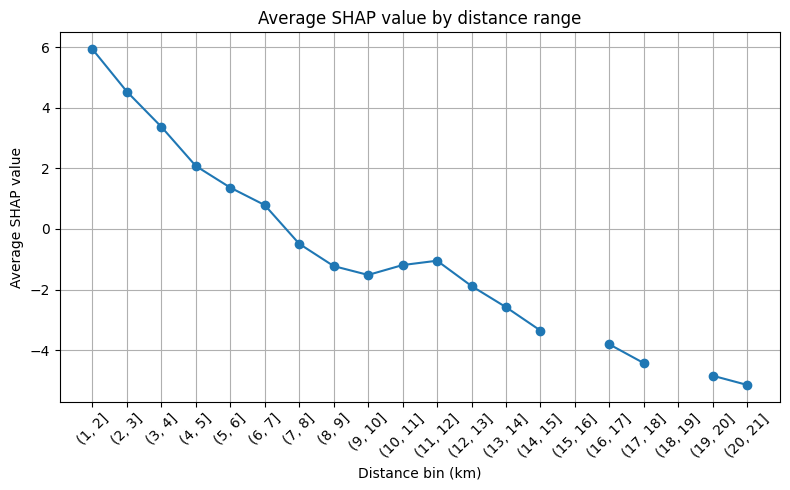

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(shap_bin_avg['distance_bin'].astype(str), shap_bin_avg['shap_value'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Distance bin (km)')
plt.ylabel('Average SHAP value')
plt.title('Average SHAP value by distance range')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 載入你上傳過的合併後資料（我們用 delay_minutes 建立分析）
file_path = "./zomato_combined.csv"
df = pd.read_csv(file_path)
# 刪除 multiple_deliveries 欄位為空值的 row
df_cleaned = df.dropna(subset=['multiple_deliveries'])

# 刪除 Festival 欄位為 "Yes" 或 空值的 row
df_cleaned = df_cleaned[~((df_cleaned['Festival'] == 'Yes') | (df_cleaned['Festival'].isna()))]
df_cleaned.drop(columns=['Festival'])

# 修正欄位名稱並計算 delay_minutes
df_cleaned['delay_minutes'] = df_cleaned['Time_taken (min)'] - df_cleaned['Estimated_duration_minutes']

# 篩選短距離訂單（距離 ≤ 6 km）
short_orders = df_cleaned[df_cleaned['distance_km'] <= 6].copy()

# 敘述統計（短距離訂單的 delay_minutes）
desc_stats = short_orders['delay_minutes'].describe().round(2)
desc_stats



,delay_minutes
count,11218.00
mean,7.60
std,9.73
min,-58.00
25%,2.00
50%,8.00
75%,14.00
max,47.00


## 所有訂單中有多少是短距離訂單

In [ ]:
import pandas as pd


# 總訂單數與短距離訂單數（小於等於 6 公里）
total_orders = len(df_cleaned)
short_orders = df_cleaned[df_cleaned['distance_km'] <= 6]
short_count = len(short_orders)
short_ratio = short_count / total_orders

print(f"Total number of orders: {total_orders}")
print(f"Number of short-distance orders (≤ 6 km): {short_count}")
print(f"Proportion of short-distance orders: {short_ratio:.2%}")


Total number of orders: 38835
Number of short-distance orders (≤ 6 km): 11218
Proportion of short-distance orders: 28.89%


## 所有**延遲**訂單中有多少是短距離訂單


In [ ]:
import pandas as pd


# 找出延遲訂單（delay_minutes > 0）
delayed_orders = df_cleaned[df_cleaned['delay_minutes'] > 0]

# 延遲訂單中為短距離的筆數（距離小於等於 6 公里）
short_in_delayed = delayed_orders[delayed_orders['distance_km'] <= 6]

# 統計數量與比例
short_count = len(short_in_delayed)
total_delayed = len(delayed_orders)
short_ratio = short_count / total_delayed

# 回傳結果
{
    "Total delayed orders": total_delayed,
    "Short-distance delayed orders (<=6 km)": short_count,
    "Proportion": round(short_ratio, 4)
}


{'Total delayed orders': 14403,
 'Short-distance delayed orders (<=6 km)': 8904,
 'Proportion': 0.6182}

## 補充：卡方檢定（H₀：配送延遲與距離類型（短距離 / 長距離）彼此獨立）

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# 定義短距離與延遲欄位
df_cleaned['short_distance'] = df_cleaned['distance_km'] <= 6
df_cleaned['is_delayed'] = df_cleaned['delay_minutes'] > 0

# 建立列聯表（交叉表）
contingency_table = pd.crosstab(df_cleaned['short_distance'], df_cleaned['is_delayed'])

# 印出交叉表
print("Contingency Table (Short Distance vs. Delay):")
print(contingency_table)

# 執行卡方檢定
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 輸出檢定結果
print("\nChi-Square Test Results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom  : {dof}")
print(f"P-value             : {p:.20f}")


Contingency Table (Short Distance vs. Delay):
is_delayed      False  True 
short_distance              
False           22118   5499
True             2314   8904

Chi-Square Test Results:
Chi-square statistic: 12085.7340
Degrees of freedom  : 1
P-value             : 0.00000000000000000000


## 所有**短距離訂單**中有多少是延遲訂單

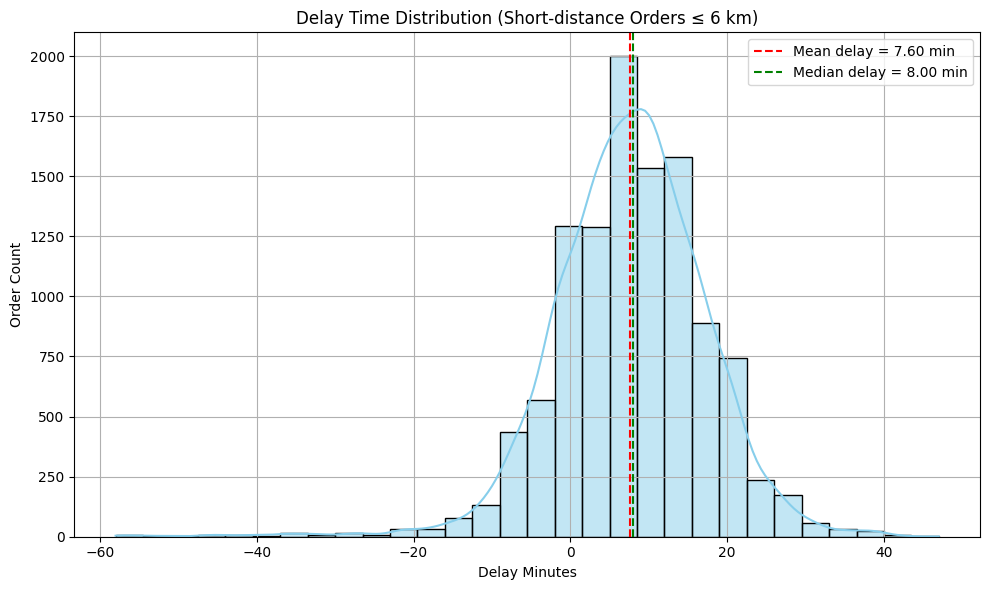

In [ ]:
# 計算平均與中位數
mean_delay = short_orders['delay_minutes'].mean()
median_delay = short_orders['delay_minutes'].median()

# 重新繪圖並標註統計數字
plt.figure(figsize=(10, 6))
sns.histplot(short_orders['delay_minutes'], bins=30, kde=True, color='skyblue')
plt.axvline(mean_delay, color='red', linestyle='--', label=f'Mean delay = {mean_delay:.2f} min')
plt.axvline(median_delay, color='green', linestyle='--', label=f'Median delay = {median_delay:.2f} min')

# 標題與座標軸
plt.title('Delay Time Distribution (Short-distance Orders ≤ 6 km)')
plt.xlabel('Delay Minutes')
plt.ylabel('Order Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 計算延遲時間 > 0 的訂單數量與比例
positive_delay_count = (short_orders['delay_minutes'] > 0).sum()
positive_delay_ratio = positive_delay_count / len(short_orders)

# 計算延遲時間 ≥ 20 的訂單數量與比例
severe_delay_count = (short_orders['delay_minutes'] >= 20).sum()
severe_delay_ratio = severe_delay_count / len(short_orders)

# 統整結果
{
    "delay_minutes > 0": {
        "count": int(positive_delay_count),
        "ratio": round(float(positive_delay_ratio), 4)
    },
    "delay_minutes ≥ 20": {
        "count": int(severe_delay_count),
        "ratio": round(float(severe_delay_ratio), 4)
    }
}



{'delay_minutes > 0': {'count': 8904, 'ratio': 0.7937},
 'delay_minutes ≥ 20': {'count': 1047, 'ratio': 0.0933}}

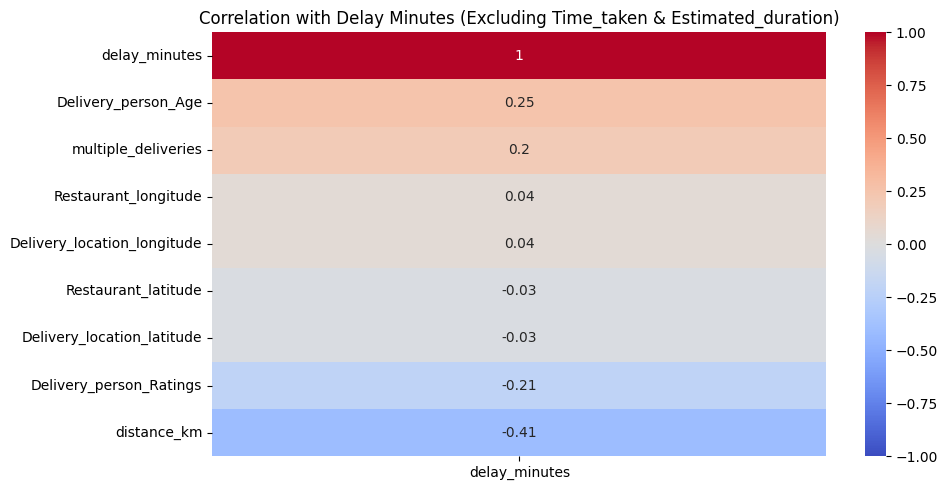

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 取得所有數值欄位（含 delay_minutes）
numeric_cols = short_orders.select_dtypes(include=['int64', 'float64']).columns.tolist()


# 移除兩個與 delay_minutes 定義直接相關的欄位
filtered_numeric_cols = [col for col in numeric_cols if col not in ['Time_taken (min)', 'Estimated_duration_minutes']]

# 重新建立相關係數矩陣
filtered_corr = short_orders[filtered_numeric_cols].corr().round(2)

# 畫出 heatmap（針對 delay_minutes 相關性）
plt.figure(figsize=(10, 5))
sns.heatmap(
    filtered_corr[['delay_minutes']].sort_values(by='delay_minutes', ascending=False),
    annot=True, cmap='coolwarm', vmin=-1, vmax=1
)
plt.title("Correlation with Delay Minutes (Excluding Time_taken & Estimated_duration)")
plt.tight_layout()
plt.show()


<ipython-input-81-7f658d81045e>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  short_orders['Time_Ordered_Hour'] = pd.to_datetime(short_orders['Time_Orderd'], errors='coerce').dt.hour
<ipython-input-81-7f658d81045e>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  short_orders['Time_Order_picked_Hour'] = pd.to_datetime(short_orders['Time_Order_picked'], errors='coerce').dt.hour


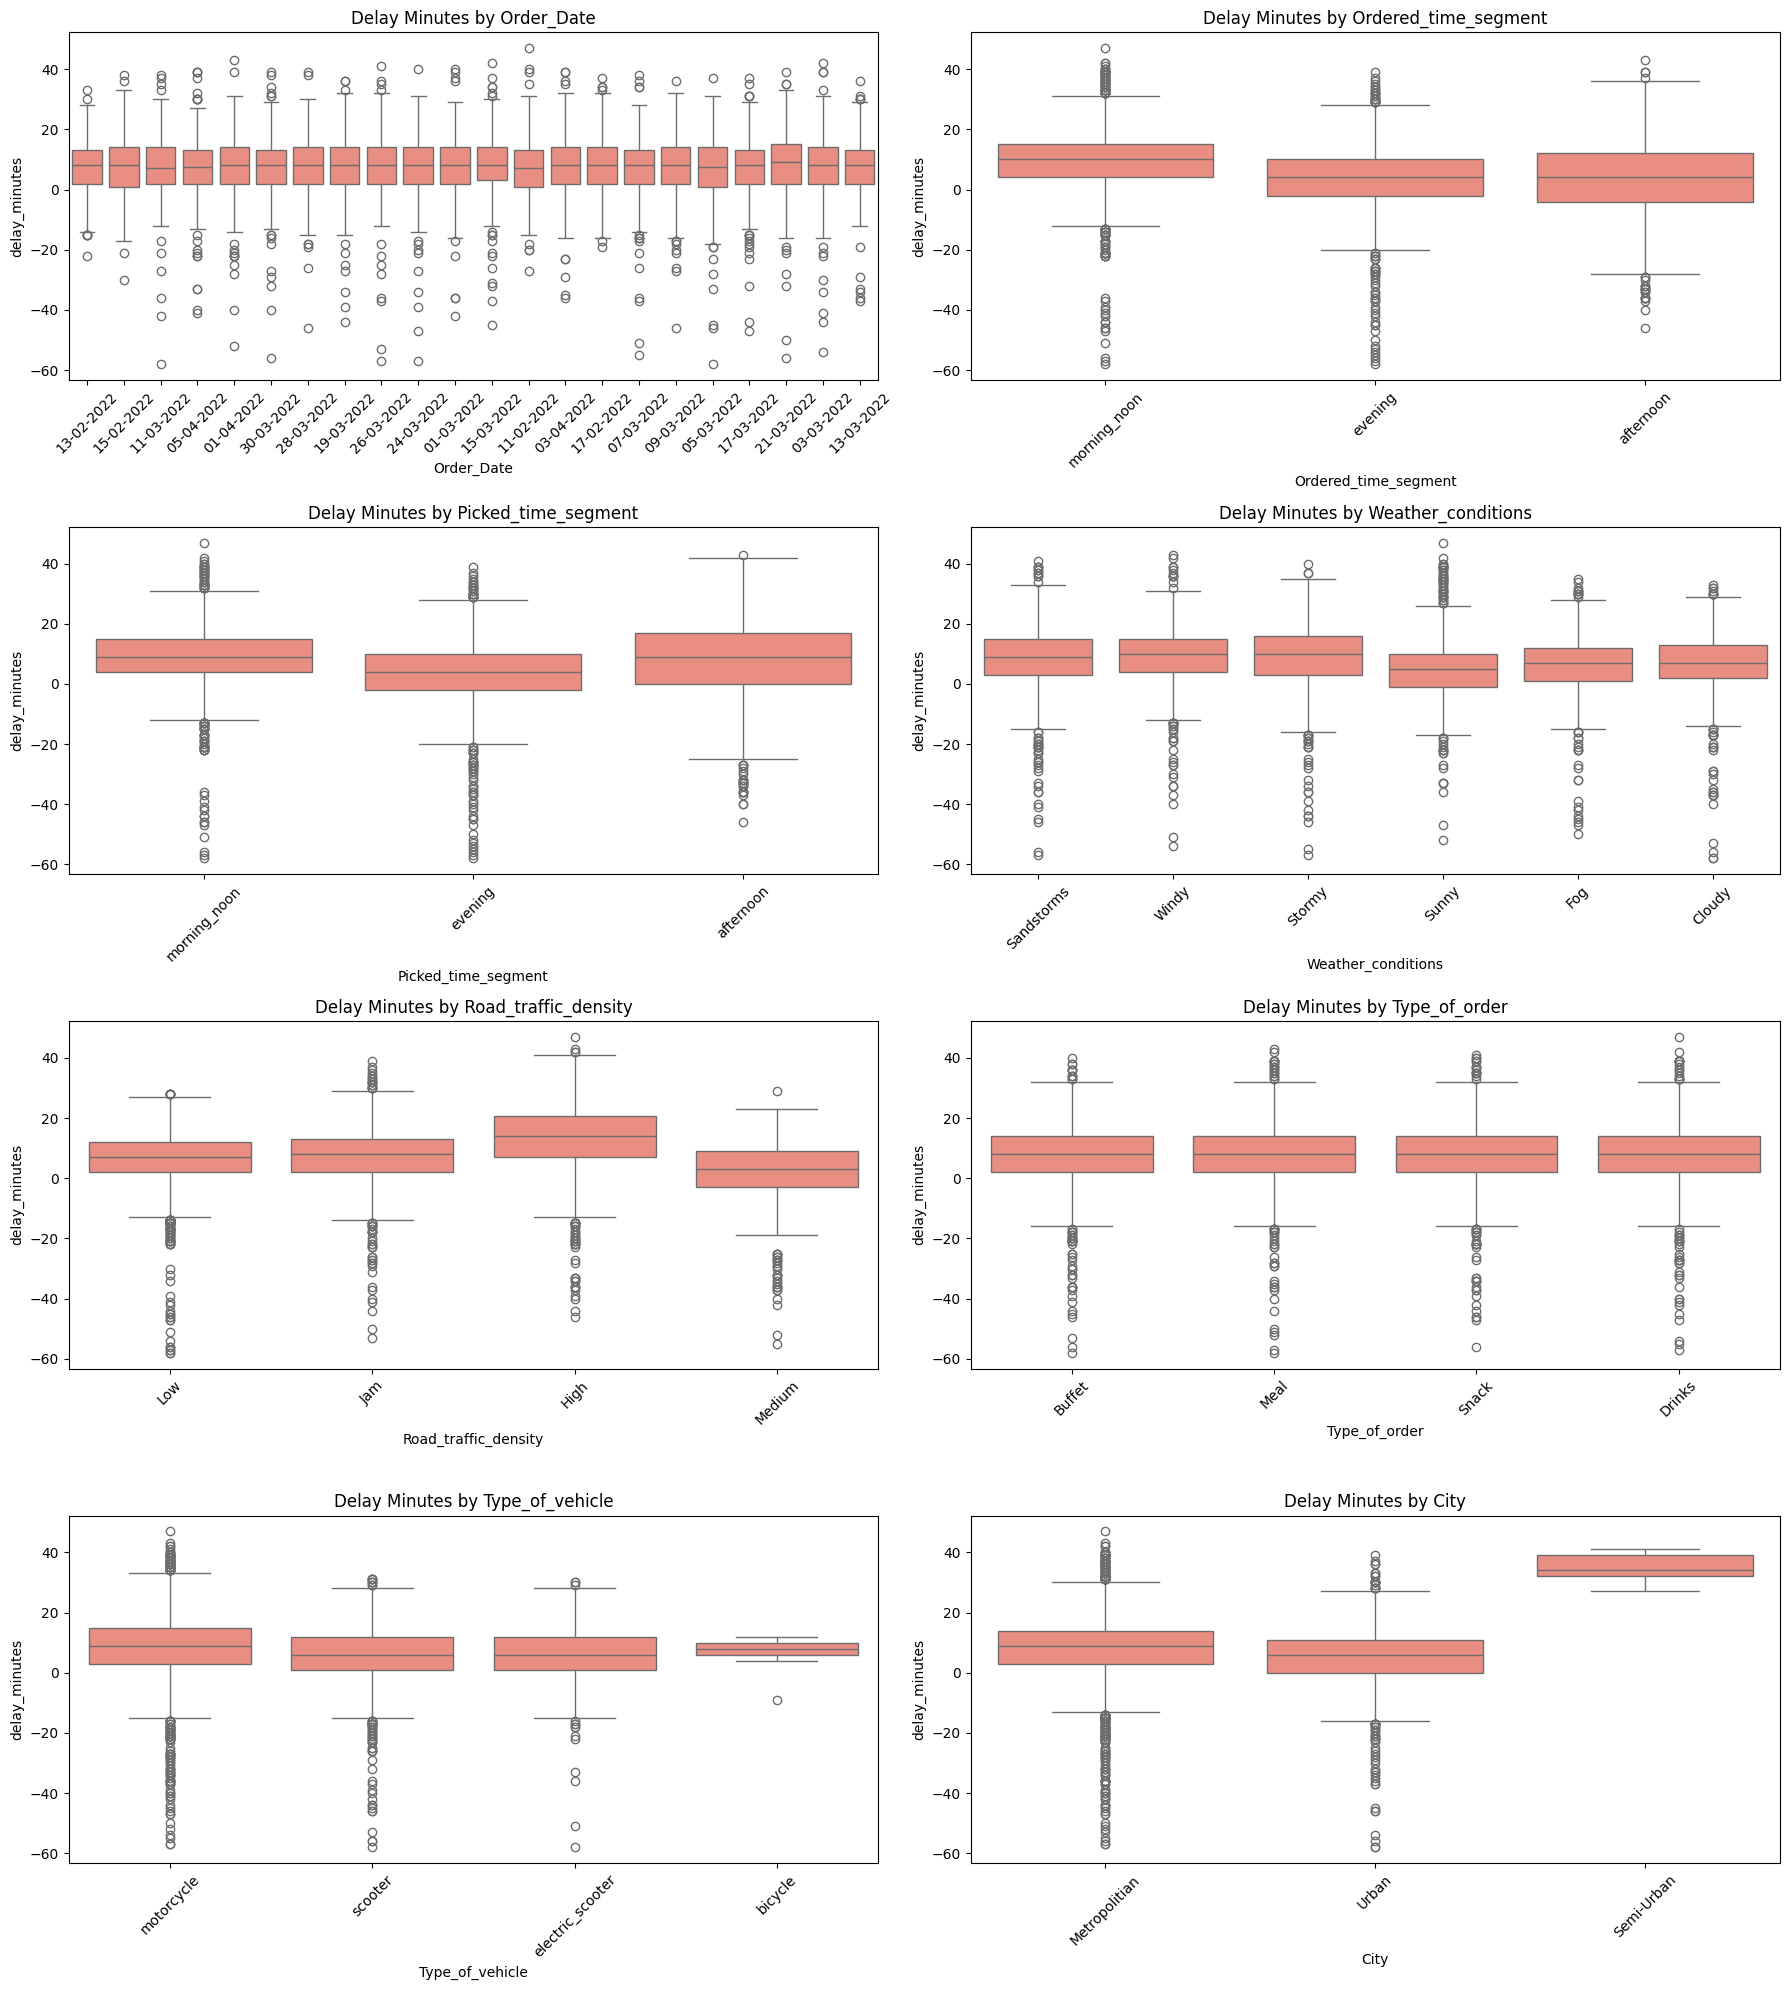

In [ ]:
# 找出類別型欄位
categorical_cols = short_orders.select_dtypes(include=['object', 'category']).columns.tolist()



# 時段分類函數
def assign_time_segment(hour):
    if pd.isnull(hour):
        return 'unknown'
    elif 8 <= hour <= 11:
        return 'morning_noon'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif hour >= 17:
        return 'evening'
    else:
        return 'other'

# 轉換時段資訊
short_orders['Time_Ordered_Hour'] = pd.to_datetime(short_orders['Time_Orderd'], errors='coerce').dt.hour
short_orders['Time_Order_picked_Hour'] = pd.to_datetime(short_orders['Time_Order_picked'], errors='coerce').dt.hour
short_orders['Ordered_time_segment'] = short_orders['Time_Ordered_Hour'].apply(assign_time_segment)
short_orders['Picked_time_segment'] = short_orders['Time_Order_picked_Hour'].apply(assign_time_segment)

# 畫出 boxplot：類別變項對 delay_minutes 的影響
categorical_vars = [
    'Order_Date', 'Ordered_time_segment', 'Picked_time_segment',
    'Weather_conditions', 'Road_traffic_density',
    'Type_of_order', 'Type_of_vehicle', 'City'
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_vars):
    if col in short_orders.columns:
        sns.boxplot(data=short_orders, x=col, y='delay_minutes', ax=axes[i], color='salmon')
        axes[i].set_title(f'Delay Minutes by {col}')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



# Preprocessing

In [ ]:
# 建立延遲分鐘數回歸模型所需的資料前處理流程

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 讀取資料
df = pd.read_csv("./zomato_combined.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_")

# 建立 delay_minutes 欄位
df['delay_minutes'] = df['Time_taken_(min)'] - df['Estimated_duration_minutes']

# 篩選短距離訂單
df_short = df[df['distance_km'] <= 6].copy()

# 刪除 multiple_deliveries 空值
df_short = df_short.dropna(subset=['multiple_deliveries'])

# 篩除 Festival == Yes 或空值
df_short = df_short[~((df_short['Festival'] == 'Yes') | (df_short['Festival'].isna()))]
df_short = df_short.drop(columns=['Festival'])

# 建立特徵與目標
X = df_short.drop(columns=[
    'Time_taken_(min)', 'Estimated_duration_minutes', 'delay_minutes', 'order_datetime'
])
y = df_short['delay_minutes']

# 時間特徵處理
X['Order_Date'] = pd.to_datetime(X['Order_Date'], format='%d-%m-%Y')
X['hour_ordered'] = pd.to_datetime(df_short['Time_Orderd'], format='%H:%M', errors='coerce').dt.hour
X['hour_picked'] = pd.to_datetime(df_short['Time_Order_picked'], format='%H:%M', errors='coerce').dt.hour
X['day_of_week'] = X['Order_Date'].dt.dayofweek.astype('category')

# 時段分類
def assign_time_segment(hour):
    if pd.isnull(hour):
        return 'unknown'
    elif 8 <= hour <= 11:
        return 'morning_noon'
    elif 12 <= hour <= 16:
        return 'afternoon'
    elif hour >= 17:
        return 'evening'
    else:
        return 'other'

X['time_segment'] = X['hour_ordered'].apply(assign_time_segment)

# 移除原始時間欄位
X = X.drop(columns=['Time_Orderd', 'Time_Order_picked'])

# 特徵分類
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'datetime64']).columns.tolist()

# 前處理器建構
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 前處理完成，準備建模
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((8974, 18), (2244, 18), (8974,), (2244,))

# Linear regression

In [ ]:
# 建立 pipeline 串接前處理器與模型
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import numpy as np

# 建立 Linear Regression 模型（包含前處理）
lr_pipeline = make_pipeline(preprocessor, LinearRegression())

# 執行 10-fold cross-validation，評估 MAE、RMSE、R²
cv_mae = -cross_val_score(lr_pipeline, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
cv_rmse = np.sqrt(-cross_val_score(lr_pipeline, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(lr_pipeline, X_train, y_train, cv=10, scoring='r2')

print("Regression Evaluation Metrics (10-fold CV):")
print(f"MAE (mean) : {cv_mae.mean():.2f} minutes")
print(f"RMSE (mean): {cv_rmse.mean():.2f} minutes")
print(f"R² (mean)  : {cv_r2.mean():.2f}")



Regression Evaluation Metrics (10-fold CV):
MAE (mean) : 5.32 minutes
RMSE (mean): 7.41 minutes
R² (mean)  : 0.42


# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# 建立 pipeline（前處理 + Random Forest）
rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))

# 執行 10-fold cross-validation
cv_mae = -cross_val_score(rf_pipeline, X, y, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_rmse = np.sqrt(-cross_val_score(rf_pipeline, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(rf_pipeline, X, y, cv=10, scoring='r2')

# 顯示結果
print("Regression Evaluation Metrics (Random Forest, 10-fold CV):")
print(f"MAE (mean) : {cv_mae.mean():.2f} minutes")
print(f"RMSE (mean): {cv_rmse.mean():.2f} minutes")
print(f"R² (mean)  : {cv_r2.mean():.2f}")


KeyboardInterrupt: 

# XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# 建立 XGBoost pipeline（含前處理器）
xgb_pipeline = make_pipeline(preprocessor, XGBRegressor(n_estimators=100, random_state=42))

# 執行 10-fold cross-validation
cv_mae = -cross_val_score(xgb_pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')
cv_rmse = np.sqrt(-cross_val_score(xgb_pipeline, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(xgb_pipeline, X, y, cv=10, scoring='r2')

# 顯示結果
print("Regression Evaluation Metrics (XGBoost, 10-fold CV):")
print(f"MAE (mean) : {cv_mae.mean():.2f} minutes")
print(f"RMSE (mean): {cv_rmse.mean():.2f} minutes")
print(f"R² (mean)  : {cv_r2.mean():.2f}")


Regression Evaluation Metrics (XGBoost, 10-fold CV):
MAE (mean) : 3.73 minutes
RMSE (mean): 4.83 minutes
R² (mean)  : 0.75


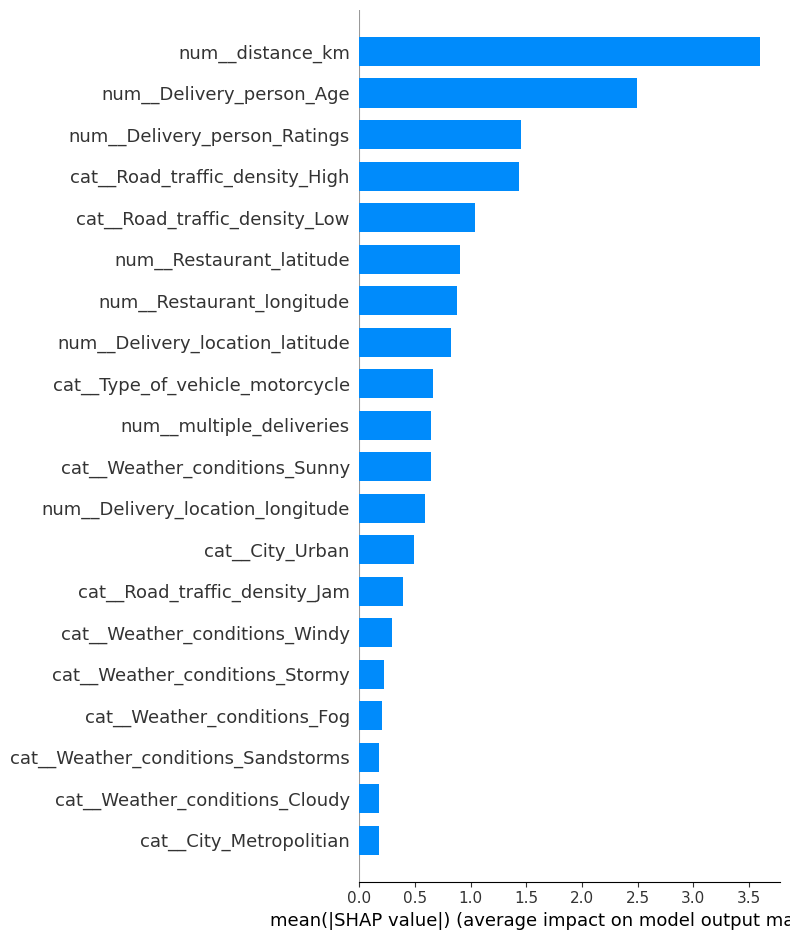

In [ ]:
import shap
import pandas as pd
import numpy as np

# Step 1: 使用 pipeline 進行 fit（你剛剛只做了 cross_val_score，沒有真的 fit）
xgb_pipeline.fit(X_train, y_train)

# Step 2: 取得訓練好的模型與特徵轉換後資料
xgb_model = xgb_pipeline.named_steps['xgbregressor']
X_test_transformed = xgb_pipeline.named_steps['columntransformer'].transform(X_test)
feature_names = xgb_pipeline.named_steps['columntransformer'].get_feature_names_out()

# Step 3: 建立 SHAP explainer（TreeExplainer 最適合 XGBoost）
explainer = shap.Explainer(xgb_model)

# Step 4: 計算 SHAP 值
shap_values = explainer(X_test_transformed)

# 取得特徵名稱（使用 ColumnTransformer 的 get_feature_names_out 方法）
feature_names = preprocessor.get_feature_names_out()

# 重新繪製 shap summary plot 並顯示特徵名稱
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar")




